In [1]:
import os
import time

import torch
from torch import nn, optim
from torch import cuda, device, utils
from torch.autograd import Variable

from torchsummary import summary
from torchvision import datasets, transforms

import numpy as np
print(cuda.is_available())
device = device('cuda:0')
print(device)

True
cuda:0


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_pcl(points, ax, nogrid):
    ax.patch.set_alpha(0)
    ax.set_xlim3d(-0.5, 0.5)
    ax.set_ylim3d(-0.5, 0.5)
    ax.set_zlim3d(-0.5, 0.5)
    ax.view_init(elev=10., azim=240.)
    if nogrid: ax.grid(False)
    ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,1], cmap='plasma', s=10)

def plot_pcls(pcls, nogrid=False):
    fig = plt.figure(figsize=(16, 8))
    for i, pcl in enumerate(pcls):
        ax = fig.add_subplot(1, 2, i + 1, projection='3d')
        plot_pcl(pcl, ax, nogrid)

In [3]:
def ShapeNetLoader(input):
    arr = np.fromfile(input, dtype=np.float32).reshape(-1, 3)
    return torch.from_numpy(arr)

class PCLDataset(utils.data.Dataset):
    
    class Downsample(object):
        def __init__(self, factor):
            self.factor = factor
        
        def __call__(self, sample):
#             sample = sample[np.random.permutation(sample.shape[0]),:]
            sample_size = 2048
            return sample[np.arange(0, sample_size, self.factor), :]

    class FilterNan(object):
        def __call__(self, sample):
            sample[sample != sample] = 0 #since nan!=nan
            return sample
    
    class Normalize(object):        
        def __call__(self, sample):
            sample -= sample.min(0, keepdim=True).values
            sample /= sample.max(0, keepdim=True).values

            return sample
    
    def __init__(self, path, ext, ldr, fctr, lim=None):
#         tfm = transforms.Compose([self.Downsample(factor=fctr), self.FilterNan(), self.Normalize()])
        self.source = datasets.DatasetFolder(root=path, extensions=(ext), loader=ldr, transform=None)
        self.size = len(self.source) if lim == None else lim
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # 0 means only samples no labels
        return self.source[idx][0].transpose(1,0)

In [4]:
class Decoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, nf),
            nn.ReLU(True),
            nn.Linear(nf, 128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048*3),
        )
    
    def forward(self, input):
        return self.net(input).view(input.size(0), 3, -1)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Discriminator, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(nc, nf, 1, 1),
            nn.LeakyReLU(0.1),

            nn.Conv1d(nf, 128, 1, 1),
            nn.LeakyReLU(0.1),

            nn.Conv1d(128, 256, 1, 1),
            nn.LeakyReLU(0.1),

            nn.Conv1d(256, 256, 1, 1),
            nn.LeakyReLU(0.1),
            
            nn.Conv1d(256, 512, 1, 1),
            nn.LeakyReLU(0.1),

#             nn.MaxPool1d(2048),
        )
        self.dec = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Linear(128, nf),
            nn.ReLU(True),
            nn.Linear(nf, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        z = self.enc(input)
        z, _ = torch.max(z, dim=-1)
        prob = self.dec(z)
        return prob
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)
        if classname.find('Linear') != -1:
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)

In [6]:
nz = 128
nf = 64
nc = 3;
mu = 0.
sigma = 0.2
batch_size = 8

dec = Decoder(nc=nc, nf=nf, nz=nz).to(device)
dec.apply(dec.weights_init)
z = torch.FloatTensor(batch_size, nz).normal_(0, 0.2).to(device)
print(z.shape)
print(dec(z).shape)
summary(dec, (1, nz))

dis = Discriminator(nc=nc, nf=nf, nz=nz).to(device)
dis.apply(dis.weights_init)
y = Variable(torch.ones((batch_size, nc, 2048)).to(device))
print(y.shape)
prob = dis(y)
print(prob.shape)
summary(dis, (nc, 2048))

torch.Size([8, 128])
torch.Size([8, 3, 2048])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           8,256
              ReLU-2                [-1, 1, 64]               0
            Linear-3               [-1, 1, 128]           8,320
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 512]          66,048
              ReLU-6               [-1, 1, 512]               0
            Linear-7              [-1, 1, 1024]         525,312
              ReLU-8              [-1, 1, 1024]               0
            Linear-9              [-1, 1, 6144]       6,297,600
Total params: 6,905,536
Trainable params: 6,905,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 26.34
Estimated Total Size (MB

In [7]:
root = '/home/artem/'
shapenet_path = 'shapenet/shape_net_core_uniform_samples_2048/03001627'

batch_size = 50
dataset = PCLDataset(os.path.join(root, shapenet_path), ext='.bin', ldr=ShapeNetLoader, fctr=1, lim=None)
dataloader = utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print('Batch size: ', batch_size)
print('Number of batches:', len(dataloader))

Batch size:  50
Number of batches: 135


torch.Size([50, 3, 2048])


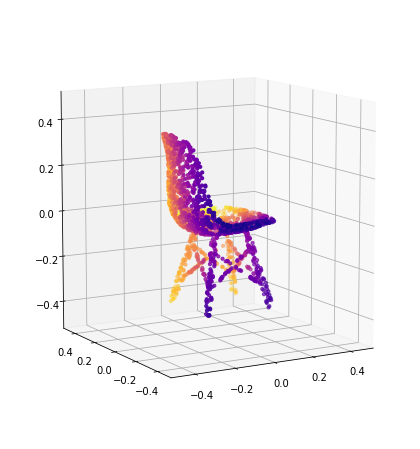

In [8]:
idx, (dataA) = next(enumerate(dataloader))
x = Variable(dataA).to(device)
print(x.shape)
plot_pcls([x.cpu().detach().numpy()[0].transpose(1,0)])

In [9]:
lrg = 1e-4
lrd = 1e-4
b1 = 0.5
b2 = 0.999
wd = 1e-3

optimizer_gen = optim.Adam(params=dec.parameters(), lr=lrg, betas=(b1, b2))
optimizer_dis = optim.Adam(params=dis.parameters(), lr=lrd, betas=(b1, b2))

criterion_adv = nn.BCELoss().to(device) 

class GenLoss(nn.Module):
    def __init__(self):
        super(GenLoss, self).__init__()

    def __call__(self, synt):
        return torch.mean(-torch.log(synt)) 

criterion_gen = GenLoss().to(device)

class DisLoss(nn.Module):
    def __init__(self):
        super(DisLoss, self).__init__()

    def __call__(self, real, synt):
        return torch.mean(-torch.log(real) - torch.log(1 - synt))

criterion_dis = DisLoss().to(device)

In [10]:
epochs = 200

gen_losses = []
dis_losses = []

print_iter = 10
print_iter = len(dataloader) / 2#20
for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    
    for idx, (dataA) in enumerate(dataloader):
        print(idx, end='\r')
        start = time.time()
        batch_size = dataA.shape[0]
#         if idx == 1: break
        
        x = Variable(dataA).to(device)
        z = torch.FloatTensor(batch_size, nz).normal_(0., 0.2).to(device)
        rec = dec(z)
        
        prob_x = dis(x)
        prob_rec = dis(rec)
        prob_real = Variable(torch.ones((batch_size, 1)).to(device))
        prob_fake = Variable(torch.zeros((batch_size, 1)).to(device))
        gen_loss = criterion_adv(prob_rec, prob_real)
#         gen_loss = criterion_gen(prob_rec)

        optimizer_gen.zero_grad()
        gen_loss.backward(retain_graph=True)
        optimizer_gen.step()
        gen_losses.append(gen_loss.item())
        
        optimizer_dis.zero_grad()
        dis_real_loss = criterion_adv(prob_x, prob_real)
        dis_rec_loss = criterion_adv(prob_rec, prob_fake)
        dis_loss = dis_real_loss + dis_rec_loss
#         dis_loss = criterion_dis(prob_x, prob_rec)
        
        dis_loss.backward()
        optimizer_dis.step()
        dis_losses.append(dis_loss.item())
        
        if not (idx % print_iter):
            print('[%d/%d;%d/%d]: gen_loss: %.3f,'
                  ' dis_loss: %.3f'
              % (idx, len(dataloader), (epoch), epochs, 
                 torch.mean(torch.FloatTensor(gen_losses)),
                 torch.mean(torch.FloatTensor(dis_losses))))
    print('Time: ', time.time() - epoch_start)

[0/135;1/200]: gen_loss: 0.667, dis_loss: 1.296
Time:  14.649923324584961
[0/135;2/200]: gen_loss: 0.719, dis_loss: 1.306
Time:  14.639853477478027
[0/135;3/200]: gen_loss: 0.746, dis_loss: 1.255
Time:  14.69885802268982
[0/135;4/200]: gen_loss: 0.833, dis_loss: 1.149
Time:  14.77580189704895
[0/135;5/200]: gen_loss: 0.925, dis_loss: 1.079
Time:  14.845627546310425
[0/135;6/200]: gen_loss: 0.924, dis_loss: 1.096
Time:  14.831190347671509
[0/135;7/200]: gen_loss: 0.930, dis_loss: 1.093
Time:  14.825266599655151
[0/135;8/200]: gen_loss: 0.948, dis_loss: 1.082
Time:  14.742625951766968
[0/135;9/200]: gen_loss: 0.951, dis_loss: 1.084
Time:  14.797276973724365
[0/135;10/200]: gen_loss: 0.955, dis_loss: 1.082
Time:  14.897533178329468
[0/135;11/200]: gen_loss: 0.963, dis_loss: 1.080
Time:  14.919031381607056
[0/135;12/200]: gen_loss: 0.966, dis_loss: 1.076
Time:  15.007802486419678
[0/135;13/200]: gen_loss: 0.974, dis_loss: 1.069
Time:  15.005606174468994
[0/135;14/200]: gen_loss: 0.987, dis

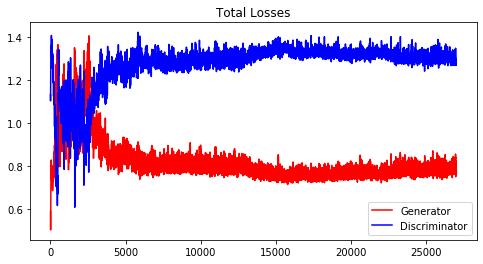

In [11]:
def running_mean(data_set, periods=10):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

rm_gen = running_mean(np.asarray(gen_losses))
rm_dis = running_mean(np.asarray(dis_losses))
plt.plot(range(0, len(rm_gen)), rm_gen, 'r-', label='Generator')
plt.plot(range(0, len(rm_dis)), rm_dis, 'b-', label='Discriminator')
plt.gca().patch.set_alpha(0)
plt.gcf().set_size_inches(8,4)
plt.title('Total Losses')
plt.legend()
plt.show();

torch.Size([4, 3, 2048])


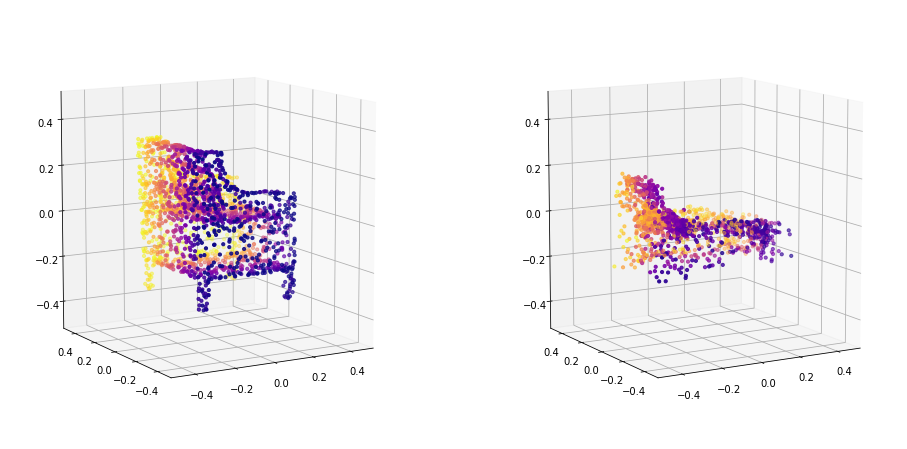

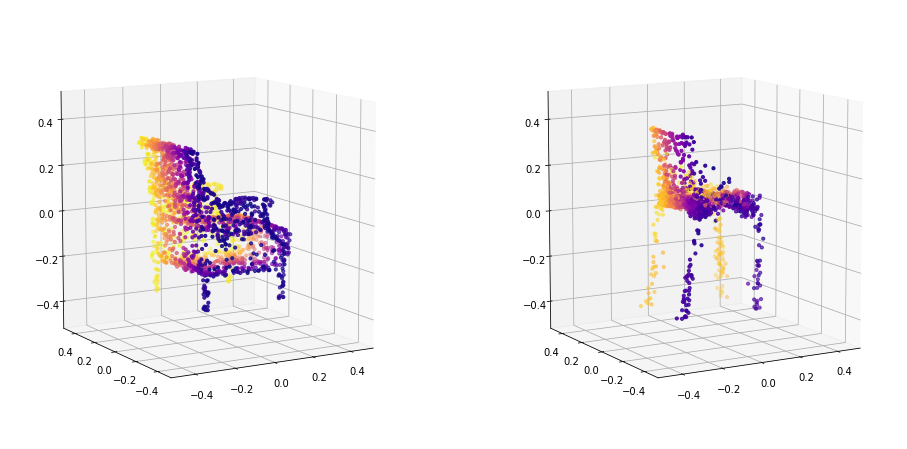

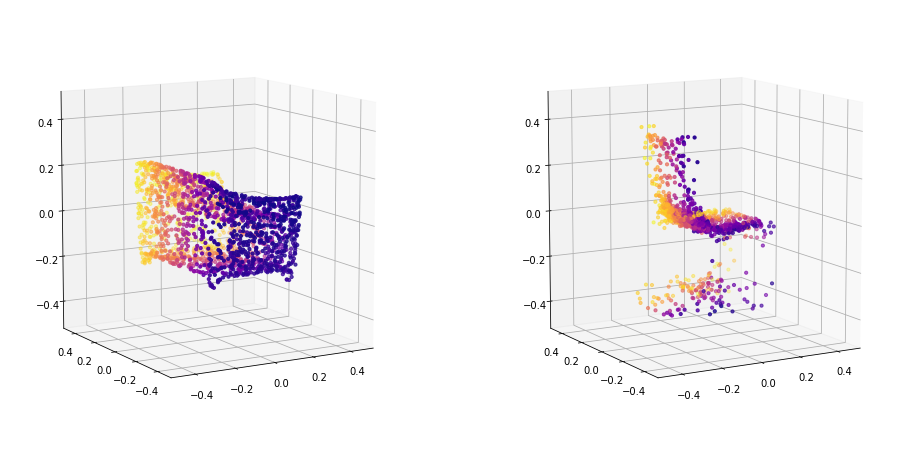

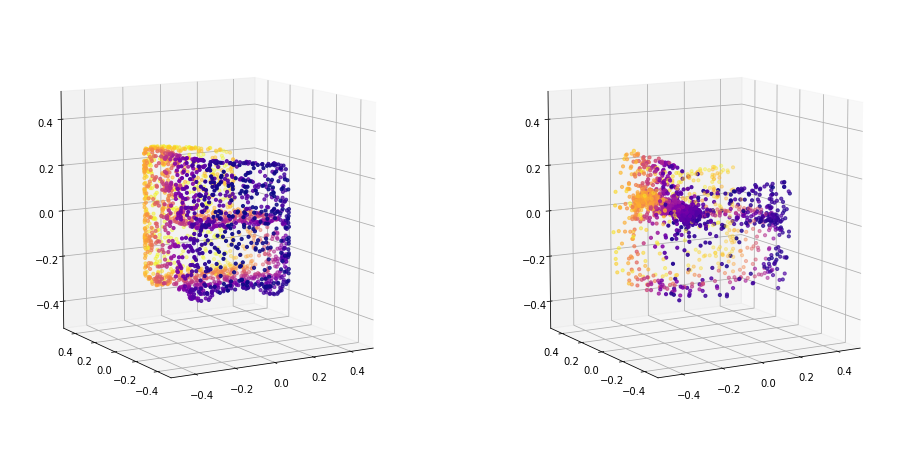

In [17]:
idx, (dataA) = next(enumerate(dataloader))
x = Variable(dataA).to(device)
# rec = decS(encS(x))
# visu_pcl(x.cpu().detach().numpy()[0].transpose(1,0), rec.cpu().detach().numpy()[0].transpose(1,0))
# visu_pcl(x.cpu().detach().numpy()[1].transpose(1,0), rec.cpu().detach().numpy()[1].transpose(1,0))
z = torch.Tensor(4, nz).normal_(0., 0.2).to(device)
rec = dec(z)
# print(rec)
print(rec.shape)
plot_pcls([x.cpu().detach().numpy()[0].transpose(1,0), rec.cpu().detach().numpy()[0].transpose(1,0)])
plot_pcls([x.cpu().detach().numpy()[1].transpose(1,0), rec.cpu().detach().numpy()[1].transpose(1,0)])
plot_pcls([x.cpu().detach().numpy()[2].transpose(1,0), rec.cpu().detach().numpy()[2].transpose(1,0)])
plot_pcls([x.cpu().detach().numpy()[3].transpose(1,0), rec.cpu().detach().numpy()[3].transpose(1,0)])